In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr,spearmanr
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import pandas_profiling

### Background
Ground-based spectrographs routinely record the spectra of stars at night and the Sun during the day. These spectra contain thousands of absorption lines which can inform us about the stellar properties and the motion of the star in radial direction.

Since a star orbits the centre of mass of the star-planet system (if there are any planets), its spectrum periodically Doppler-shifts back and forth. Convective plasma motions on the star can interfere with this Doppler signal.
Thus, it is important to have a proxy for stellar activity such that we can differentiate between stellar and planetary Doppler signals.


Measuring the average stellar magnetic field based on intensity spectra is a promising path towards reducing the stellar contribution to the radial velocity signal. This is due to the magnetic field being closely linked to stellar surface phenomena such as star spots, faculae, or plages.

### Data:
       
    About 300 solar spectra (mostly in the visible range) from ground-based observatory. For each spectrum we extract information from its absorption lines.

    Magnetic flux measurements from SDO (space-bourne) for the same observation dates.
    
    
### Model: 

    The recorded spectra can be modelled assuming a magnetic field or no magnetic field. Information can be extracted from the difference between the model and the data, the difference between the models, or the data itself.
          

### Aim: 
        
    Find a relationship between the data/model and the magnetic field.

## LOAD DATA

For each absorption line:

- wvl_absline: wavelength
- landefactors: effective lande factor 
- linedepths: depth


- mean_impr: improvement of model relative to data assuming a fixed magnetic field vs no magnetic field
- model_difference: difference between models assuming a fixed magnetic field vs no magnetic field


- mean_deviation_line: mean deviation of data from model
- std_deviation_line: std(data-model)

In [2]:
#LOAD DATA 1 (-> get masks for data cleaning)

#hemispherically averaged magnetic flux of Sun (from SDO)
bs = pd.read_csv("./data/B_field_sdo.csv")

#wavelength of absorption lines (Angstrom)
wvl_absline = pd.read_csv("./data/linepositions.csv")
linelist_wavelength = pd.read_csv("./data/linelist_position.csv").values.ravel()
linelist_depth = pd.read_csv("./data/linelist_depth.csv").values.ravel()

#LINE MASK (columns)

#distance between absorption lines
pos_diff = wvl_absline.diff()

#remove one of two absorption lines if they are overlapping (distance<=0.2 angstrom)
mask = [pos_diff>0.2]
mask = mask[0].values.ravel()

#MAGNETIC FIELD MASK (rows)
bmask = (bs["0"]>6.5) & (bs["0"]<14)
bmask = bmask.values


In [3]:
#LOAD DATA AND APPLY MASK


bs = bs[bmask]
#wavelength of absorption lines
wvl_absline = wvl_absline[mask]
#lande factor
landefactors = pd.read_csv("./data/landefactors.csv")[mask]
#depth of absorption lines
linedepths = pd.read_csv("./data/linedepths.csv")[mask]


dfs = {}

names = ["mean_impr" ,
"mean_deviation_line",
"std_deviation_line",
"model_difference"]

for name in names:
    dfs[name] = (pd.read_csv(f"./data/{name}.csv")).loc[bmask,mask]

#we need the unscaled versions of these
mean_model_deviation_unscaled = dfs["mean_deviation_line"].copy()
model_difference_unscaled = dfs["model_difference"].copy()


In [4]:
#ignore, empirical

contamination = np.zeros((wvl_absline.shape[0]))

for count,line in enumerate(wvl_absline.values.ravel()):
    cval = line/wvl_absline.mean().values[0]
    thresh = cval * 0.15
    line_distance = np.abs(linelist_wavelength-line)
    close_lines = np.where((line_distance<thresh) & (line_distance>0) ) [0]
    weight = 0.15/(line_distance[close_lines]+0.01)/15.
    contamination[count] = (linelist_depth[close_lines]*weight).sum()


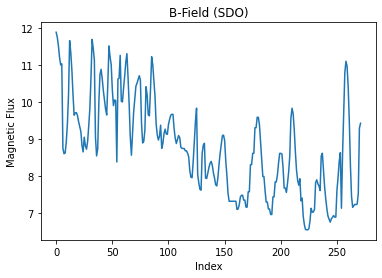

In [5]:
#TARGET VALUE

#main trend + some higher frequency terms (median time step: 1 day)

plt.figure()
plt.title("B-Field (SDO)")
plt.xlabel("Index")
plt.ylabel("Magnetic Flux")
plt.plot(bs["0"]);

## SCALE AND IMPUTE

In [6]:
#scale columns in dfs dictionary containing the data frames
for name in dfs.keys():
    scaler = StandardScaler()
    scaler.fit(dfs[name])
    dfs[name]=(pd.DataFrame(scaler.transform(dfs[name])))

Some outliers!


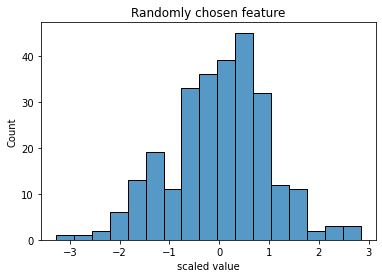

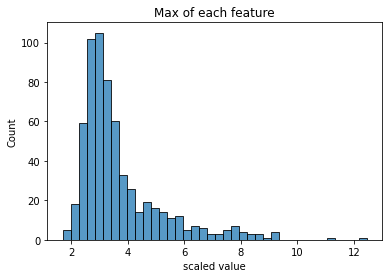

In [7]:
plt.figure()
plt.title("Randomly chosen feature")
sns.histplot(dfs["std_deviation_line"].loc[:,np.random.randint(dfs["std_deviation_line"].shape[1])])
plt.xlabel("scaled value");


plt.figure()
plt.title("Max of each feature")
sns.histplot(dfs["std_deviation_line"].max(axis=0))
plt.xlabel("scaled value");
print("Some outliers!")

In [8]:
#impute

for name in dfs.keys():

    df = dfs[name]
    df[df.abs()>5] = np.nan

    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(df)
    df = imp.transform(df)
    
    dfs[name] = pd.DataFrame(df)

In [9]:
#CHECK IF ANY NANS

for name in dfs.keys():
    df = dfs[name]
    if df.isnull().any().any():
        print("some nans")

## ANALYSE CLEAN DATA

In [10]:
ana_df = pd.DataFrame({})

#basic line parameters
ana_df["depth"] = linedepths["0"]
ana_df["landefactor"] = landefactors["0"]
ana_df["wavelength [Angstrom]"] = wvl_absline["0"]

#model behaviour
#mean over time and mean over absorption lines (-> mean mean)
ana_df["mean_mean_model_deviation"] = mean_model_deviation_unscaled.mean(axis=0).values
ana_df["std_mean_model_deviation"] = mean_model_deviation_unscaled.std(axis=0).values
ana_df["mean_model_difference"] = model_difference_unscaled.mean(axis=0).values

Rough correlation between wavelength and mean_model_difference.


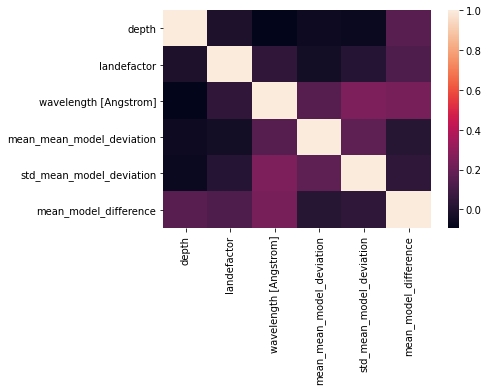

In [11]:
sns.heatmap(ana_df.corr());
print("Rough correlation between wavelength and mean_model_difference.")

1. There is a systematic wavelength-dependent offset between the model and the data.
2. The distribution in wvl of the absorption lines is not uniform. More absorption lines at shorter wavelengths -> higher contamination value (hue). This causes a slight colour gradient.


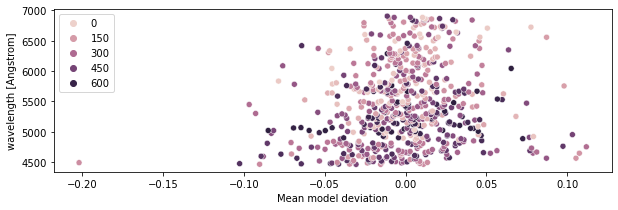

In [12]:
#This is cell 12.
plt.figure(figsize=(10,3))
sns.scatterplot(x=ana_df["mean_mean_model_deviation"],y=ana_df["wavelength [Angstrom]"],hue=np.argsort(contamination));
plt.xlabel("Mean model deviation")
print("1. There is a systematic wavelength-dependent offset between the model and the data.")
print("2. The distribution in wvl of the absorption lines is not uniform. More absorption lines at shorter wavelengths -> higher contamination value (hue). This causes a slight colour gradient.")

The same result as above. Absorption lines at high/low wavelengths are not perfectly fit by the model.


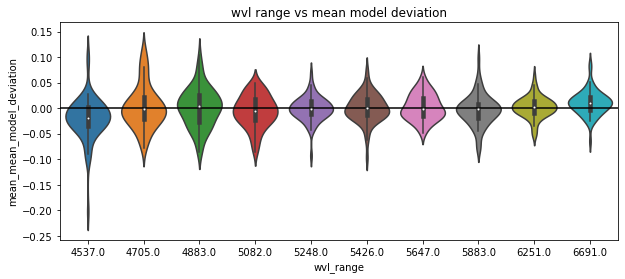

In [13]:
wvl_range = ana_df["wavelength [Angstrom]"].values.ravel()
binned_wvl_range = (wvl_range.argsort()/len(wvl_range)*10).astype(int) #sorry

plt.figure(figsize=(10,4))
plt.title("wvl range vs mean model deviation")
ax = sns.violinplot(y=ana_df["mean_mean_model_deviation"],x=binned_wvl_range,scale="count");

labels = ana_df["wavelength [Angstrom]"].groupby(binned_wvl_range).agg(["mean"]).round().values.ravel()

ax.set_xticklabels(labels)
plt.axhline(0,color="k")
plt.xlabel("wvl_range");
print("The same result as above. Absorption lines at high/low wavelengths are not perfectly fit by the model.")

Higher contamination for shorter wavelengths.


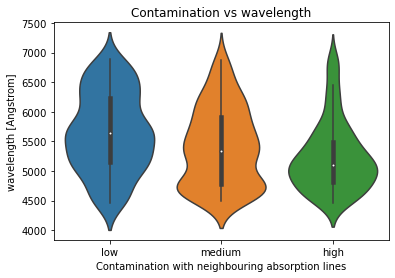

In [14]:
binned_contamination = (contamination.argsort()/len(contamination)*3).astype(int)

plt.figure()
plt.title("Contamination vs wavelength")
ax = sns.violinplot(y=ana_df["wavelength [Angstrom]"],x=binned_contamination,scale="count");
ax.set_xticklabels(["low","medium","high"])
plt.xlabel("Contamination with neighbouring absorption lines");
print("Higher contamination for shorter wavelengths.")

In [15]:
#sns.regplot(np.argsort(contamination),ana_df["mean_model_difference"],".")
#plt.xlabel("Ranked contamination");

## FIND CORRELATIONS WITH MAGNETIC FIELD

Some variables (such as the mean model deviation) correlate with the magnetic field. 
Pearson correlation coefficient: -0.36


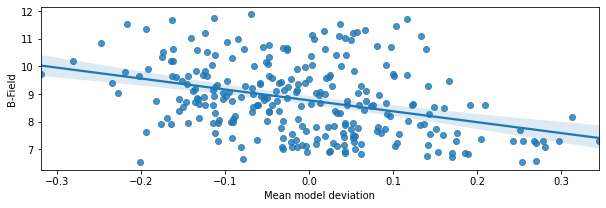

In [16]:
plt.figure(figsize=(10,3))

#scaled version this time
sns.regplot(x=dfs["mean_deviation_line"].mean(axis=1),y=bs["0"])
plt.xlabel("Mean model deviation")
plt.ylabel("B-Field");

p_corr = pearsonr(dfs["mean_deviation_line"].mean(axis=1),bs["0"])[0]
print(f"Some variables (such as the mean model deviation) correlate with the magnetic field. \nPearson correlation coefficient: {p_corr:.2f}")


In [17]:
def lin_reg(X,res,alpha):
    
    predictor = Ridge(fit_intercept=True,alpha=alpha)
    #predictor = LinearRegression(fit_intercept=True)

    predictor.fit(X=X, y=res)
    return predictor

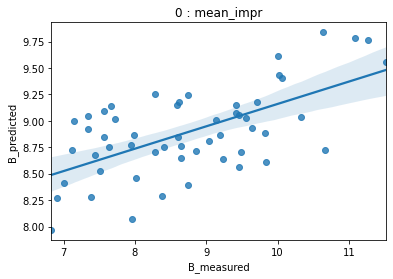

pearson: 0.62            score: 0.29
----------------------------------------------------------------------------------------------------


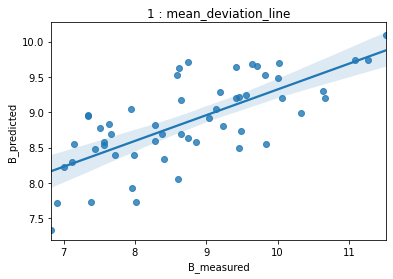

pearson: 0.72            score: 0.46
----------------------------------------------------------------------------------------------------


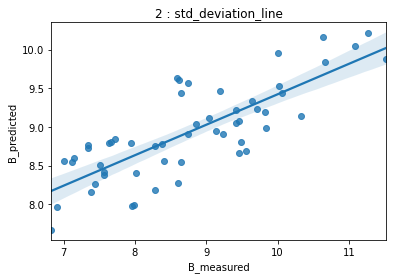

pearson: 0.80            score: 0.52
----------------------------------------------------------------------------------------------------


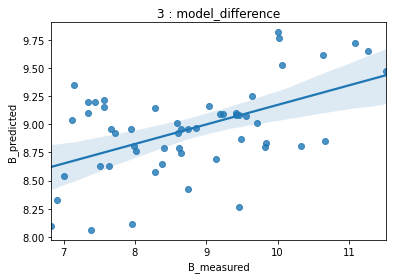

pearson: 0.52            score: 0.21
----------------------------------------------------------------------------------------------------


In [18]:
predicted = pd.DataFrame()
coefs = pd.DataFrame()

seednr = np.random.randint(1000)

for nr,name in enumerate(dfs.keys()):
    
    np.random.seed(seednr)

    df = dfs[name]

    X_all_c = df.copy()

    indices = X_all_c.index
    
    train_nr = np.int(len(indices)*0.8)
    
    contiguous = False
    
    if not contiguous:
        train_indices = sorted(np.random.choice(indices,train_nr,replace=False))
        test_indices = [i for i in indices if i not in train_indices]
    else:
        trind = [False]*(len(indices)-train_nr) + [True]*train_nr
        
        s = np.random.randint(train_nr)
        trind = np.roll(trind,s)
        
        train_indices = indices[trind]
        test_indices = [i for i in indices if i not in train_indices]

    
    #random indices

    X_train = X_all_c.loc[train_indices]
    B_train = bs.values.ravel()[train_indices]

    X_test = X_all_c.loc[test_indices]
    B_test = bs.values.ravel()[test_indices]


    predictor = lin_reg(X_train,B_train,1000)
    
    prediction_test = predictor.predict(X_test)

    predicted[nr] = prediction_test
    coefs[nr]=predictor.coef_[0]
    
    plt.figure()
    sns.regplot(x=B_test,y=prediction_test)
    plt.title(f"{nr} : {names[nr]}")
    plt.xlabel("B_measured")
    plt.ylabel("B_predicted")
    plt.show()
    
    print(f"pearson: {pearsonr(np.asarray(prediction_test),B_test)[0]:.2f}\
            score: {predictor.score(X_test,B_test):.2f}")
    print("-"*100)
predicted["B"]=B_test

In [19]:
#plt.hist(predictor.coef_)
#plt.xlabel("Coefficients");

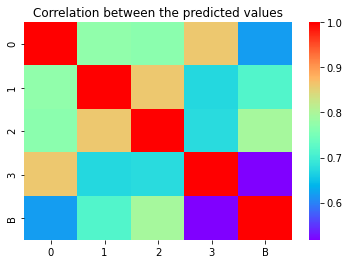

In [20]:
plt.figure()
sns.heatmap(predicted.corr(),cmap="rainbow")
plt.title("Correlation between the predicted values");

pearson:  0.78
spearman:  0.76


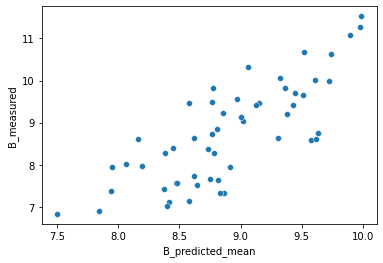

In [21]:
#select a few
selection = [1,2]

sns.scatterplot(x=predicted[selection].mean(axis=1), y=predicted["B"])
plt.xlabel("B_predicted_mean")
plt.ylabel("B_measured")
print(f"pearson: ",np.round(pearsonr(predicted[selection].mean(axis=1), predicted["B"])[0],2))
print("spearman: ",np.round(spearmanr(predicted[selection].mean(axis=1), predicted["B"])[0],2))


In [22]:
#sns.scatterplot( predicted[0].ravel(),predicted[4].ravel())

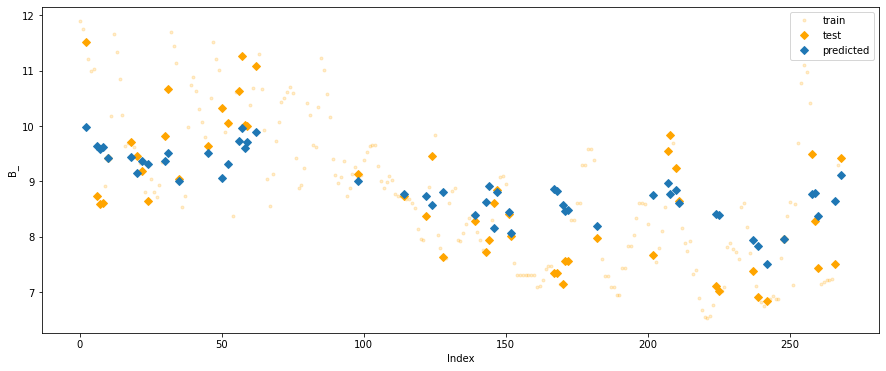

In [23]:
plt.figure(figsize=(15,6))
plt.plot(train_indices,B_train,".",color="orange",alpha=0.2,label="train")
plt.plot(test_indices,B_test,"D",color="orange",label="test")
plt.plot(test_indices,predicted[selection].mean(axis=1),"D",label="predicted")

plt.xlabel("Index")
plt.ylabel("B_")
plt.legend();



The predicted magnetic flux values are very close to the measured values. However, if we set the 'contiguous' parameter above to 'True', the correlation is almost gone. -> The linear regression is able to extrapolate from similar profiles (close in time). Training on more spectra could help, but we we typically do not have more than 200 spectra for one star.

## DEPENDENCE ON SOME PARAMETERS

In [24]:
def corr_rep(alphas,rep,contig,pct):
    corrs = {}
    for alpha in alphas:
        corrs[alpha] = np.zeros((rep))
        
    df = dfs["std_deviation_line"]

    X_all = df.copy()
    include_good_lines = (contamination<np.percentile(contamination,pct))
    X_all_c = X_all.loc[:,include_good_lines]

    indices = X_all_c.index
    train_nr = np.int(len(indices)*0.8)
        
    for i in range(rep):

        if not contig:
            train_indices = sorted(np.random.choice(indices,train_nr,replace=False))
            test_indices = [i for i in indices if i not in train_indices]
        else:
            trind = [False]*(len(indices)-train_nr) + [True]*train_nr
            s = np.random.randint(train_nr)
            #shift in time series
            trind = np.roll(trind,s)
            train_indices = indices[trind]
            test_indices = [i for i in indices if i not in train_indices]

        X_train = X_all_c.loc[train_indices]
        B_train = bs.values.ravel()[train_indices]

        X_test = X_all_c.loc[test_indices]
        B_test = bs.values.ravel()[test_indices]
        
        for alpha in alphas:
            predictor = lin_reg(X_train,B_train,alpha)

            prediction_test = predictor.predict(X_test)

            p = pearsonr(np.asarray(prediction_test),B_test)[0]

            corrs[alpha][i] = p
    return corrs

Since there is some information in most absorption lines, a relatively high alpha value is beneficial.


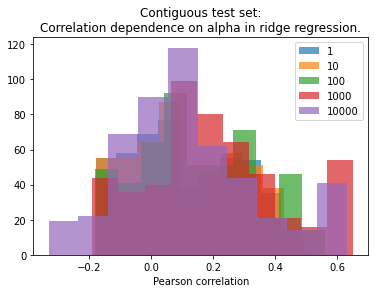

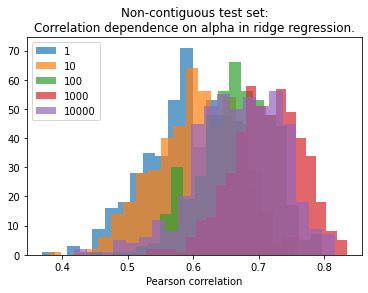

In [25]:
alphas = [1,10,100,1000,10000]

corrs_contiguous = corr_rep(alphas,500,True,90)
corrs_noncontiguous = corr_rep(alphas,500,False,90)



plt.figure()
plt.title("Contiguous test set:\nCorrelation dependence on alpha in ridge regression.")
for alpha in alphas:
    plt.hist(corrs_contiguous[alpha],bins=10,label=alpha,alpha=0.7)
plt.xlabel("Pearson correlation")
plt.legend();

plt.figure()
plt.title("Non-contiguous test set:\nCorrelation dependence on alpha in ridge regression.")
for alpha in alphas:
    plt.hist(corrs_noncontiguous[alpha],bins=20,label=alpha,alpha=0.7)
plt.xlabel("Pearson correlation")
plt.legend();
print("Since there is some information in most absorption lines, a relatively high alpha value is beneficial.")

Exclude contaminated absorption lines?


Pearson correlation: 

percentile 	mean, median, std
70 	 	[0.701 0.704 0.059]
80 	 	[0.71  0.714 0.057]
90 	 	[0.715 0.719 0.055]
100 	 	[0.725 0.73  0.057]


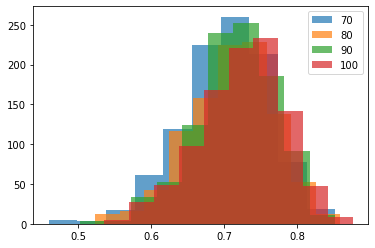

In [26]:
plt.figure()
print("Exclude contaminated absorption lines?\n\n")
print("Pearson correlation: \n\npercentile \tmean, median, std")
for percentile in [70,80,90,100]:
    d = corr_rep([1000],1000,False,percentile)[1000]
    print(f"{percentile } \t \t{np.round([np.mean(d),np.median(d),np.std(d)],3)}")
    plt.hist(d,label=percentile,alpha=0.7)
plt.legend();

## SUMMARY

### Model weaknesses

The figure in cell 12 (violet scatter plot) indicates that our model struggles to fit all absorption lines equally well. More specifically, the intrinsic assumption of line similarity is not warranted over large wavelength ranges.

### Exclude some absorption lines?

While it is tempting to remove absorption lines based on some criteria (for example contamination), his turned out to reduce the correlation of the predicted magnetic fluxes with the measured fluxes for both the contiguous and the non-contiguous test case.

### What can we predict?

If the indices of the training set are randomly distributed over the time series, we can predict the missing values very well (mean Pearson correlation: 0.7).
If a contiguous chunk of the data is chosen to be the test set, the correlation between the measured and the estimated B-Fluxes is relatively low (mean Pearson correlation: 0.2).
More data could solve this problem, but typically, we do not have more than 200 spectra at hand.

The temporally-limited linear behaviour of the absorption line deviations is remarkable, however, and shows that there is extractable magnetic information in the absorption lines.



